# Analiza ogłoszeń sprzedaży samochodów używanych

## 0. Zbiór danych
Analiza dotyczy zbioru danych udostępnionego w portalu kaggle.com, w którym znajdują się dane sprzedawanych samochodów używanych pobrane z niemieckiego portalu aukcyjnego ebay. Oryginalne dane w pliku *csv* dostępne są pod niniejszym adresem https://www.kaggle.com/orgesleka/used-cars-database

### 0.1. Cel projektu
Cele projektu są następujące:
- przedstawienie w praktyce umiejętności i wiedzy nabytych w trakcie studiów podyplomowych
- przyswojenie i spełnienie wymagań stawianych przez schemat postępowania CRISP-DM
- utworzenie modelu regresji liniowej do szacowania ceny samochodu używanego

### 0.2. Wymagania projektu
Wymagania co do projektu są następujące:
- spełnienie celów z Podrozdziału 0.1.
- wykonanie raportu obrazującego przebieg postępowania analizy danych

In [42]:
#import niezbędnych modułów: pandas, numpy, seaborn i matplotlib.pyplot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Przygotowanie danych
### 1.1. Zapoznanie się z danymi
Pierwszym etapem przygotowania danych jest zapoznanie się z nimi. Dane zawierają ponad 370000 obserwacji w 20 kolumnach. Poniżej zostały wypisane kolumny danych, typy danych w kolumnach, liczba brakujących (pustych) obserwacji w danych kolumnach oraz dwie pierwsze obserwacje z każdej kolumny. Dane występują w dwóch typach, to jest jako napisy (typ *object*) oraz dane liczbowe (typ *int64*). Część danych zapisanych jako napisy to dane kategoryczne, których przygotowanie odbędzie się w kolejnym kroku. W zbiorze występują również dane typu data i czas, które będą wymagały konwersji typu. Poza tym w zbiorze występuje spora liczba pustych obserwacji. Łączna liczba brakujących elementów to ponad 184000. Liczba obserwacji, w którym występuje choć jeden pusty element jest na szczęście mniejsza i wynosi 110572 co stanowi prawie 30% wszystkich obserwacji.

In [43]:
#wczytanie zbioru danych z pliku csv w kodowaniu ansi (kodek mbcs) jako ramkę danych
cars = pd.read_csv("cars.csv", encoding = "mbcs")

#zapoznanie się z danymi
size = cars.shape
headers = list(cars.head()) #wydobycie nagłówków
head = dict(cars.head()) #słownik na potrzeby formatowania
types = cars.dtypes
nans = [cars[i].isnull().sum() for i in cars] #sprawdzenie brakujących danych

#sprawdzenie wierszy, w których jest co najmniej jeden pusty rekord
nonempty_matrix = [cars[i].notnull() for i in cars]
nonempty_conjuction = nonempty_matrix[0]
for i in range(1, len(nonempty_matrix)):
    nonempty_conjuction &= nonempty_matrix[i] 

#wyświetlenie sformatowanego opisu zbioru danych
print("Liczba obserwacji: %s, liczba kolumn: %s" % (size[0], size[1]))
print("Liczba wierszy bez żadnego pustego elementu %s \n" % nonempty_conjuction.sum())
for i in range(len(headers)):
    print("%s: %s, TYP: %s, BRAK: %s, ZMIENNE: %s, %s" % (i, 
                                                          headers[i], 
                                                          types[i], 
                                                          nans[i], 
                                                          head[headers[i]][0], 
                                                          head[headers[i]][1]))

Liczba obserwacji: 371528, liczba kolumn: 20
Liczba wierszy bez żadnego pustego elementu 260956 

0: dateCrawled, TYP: object, BRAK: 0, ZMIENNE: 2016-03-24 11:52:17, 2016-03-24 10:58:45
1: name, TYP: object, BRAK: 0, ZMIENNE: Golf_3_1.6, A5_Sportback_2.7_Tdi
2: seller, TYP: object, BRAK: 0, ZMIENNE: privat, privat
3: offerType, TYP: object, BRAK: 0, ZMIENNE: Angebot, Angebot
4: price, TYP: int64, BRAK: 0, ZMIENNE: 480, 18300
5: abtest, TYP: object, BRAK: 0, ZMIENNE: test, test
6: vehicleType, TYP: object, BRAK: 37869, ZMIENNE: nan, coupe
7: yearOfRegistration, TYP: int64, BRAK: 0, ZMIENNE: 1993, 2011
8: gearbox, TYP: object, BRAK: 20209, ZMIENNE: manuell, manuell
9: powerPS, TYP: int64, BRAK: 0, ZMIENNE: 0, 190
10: model, TYP: object, BRAK: 20484, ZMIENNE: golf, nan
11: kilometer, TYP: int64, BRAK: 0, ZMIENNE: 150000, 125000
12: monthOfRegistration, TYP: int64, BRAK: 0, ZMIENNE: 0, 5
13: fuelType, TYP: object, BRAK: 33386, ZMIENNE: benzin, diesel
14: brand, TYP: object, BRAK: 0, ZMIENN

### 1.2. Przygotowanie danych kategorycznych
Dla kolumny **seller** występują dwie kategorie, z których jedna zawiera jedynie 3 elementy. Z tego powodu ta kolumna zostanie usunięta w dalszym etapie, ponieważ nie wnosi żadnych danych do zbioru. Podobnie jest w przypadku kolumny **offerType**. Tutaj kategoria *Gesuch* zawiera tylko 12 elementów, a więc i ta kolumna zostanie usunięta. Wykluczona ze zbioru danych zostanie również kolumna **abtest**, ponieważ danych w niej nie można zinterpretować.

Kolumna **gearbox** jest istotna, a w dodatku nie zawiera pustych elementów. Zostanie więc pozostawiona w niezmienionej formie.

W kolumnie **fuelType** jest 7 kategorii, lecz niektóre z nich zawierają małą liczbę obserwacji (poniżej 600). Tak jest w przypadku kategorii *andere*, *elektro*, *hybrid* oraz *cng*. Ze względu na podobieństwo samochodów z instalacjami gazowymi zostanie utworzona wspólna kategoria *gas* dla otrzymanych kategorii *lpg* i *cng*. Pozostałe z wymienionych kategorii zostaną usunięte wraz z danymi wewnątrz nich.

Kolumna **notRepairedDamage** zawiera bardzo ważne informacje o tym czy samochód jest uszkodzony czy naprawiony lub nieuszkodzony. Dane te wydają się istotne dla dalszej analizy, mimo tego, że zawierają aż 72060 pustych obserwacji. Puste elementy zostaną usunięte.

Kolumna **brand** zawiera marki wystawionych na sprzedaż samochodów. Jest w niej 39 kategorii, z których najwięcej, 79640 obserwacji zawiera kategoria *volkswagen*. Ta liczba stanowi 21% wszystkich danych.

W kolumnie **model** występuje 251 kategorii i dane w niej są mocno rozproszone. Najczęstszą obserwacją w tej kolumnie jest *golf* w liczbie 30070, co stanowi 8% całego zbioru danych. Niestety, ta kolumna zostanie usunięta ze zbioru. Wykorzystanie jej na cele analizy wymagałoby użycia bardziej zaawansowanych metod niż przewidziano na cel niniejszego zadania z powodu dużego rozproszenia liczby obserwacji w katgoriach. Zostało to przedstawione na *Wykresie 1*.

Kolumna **vehicleType** ma 7 kategorii, z czego jedna z nich dotyczy samochodów opisanch jako *inne - andere*. Dalej przedstawiono wycinek nazw ogłoszeń samochodów z tej kategorii. Jak widać zawiera ona samochody całkowicie zniszczone, do naprawy lub przerabiane. Takie egzemplarze nie wpisują się w ogół analizowanych danych i zostaną usunięte. 

In [44]:
#wybranie kolumn z danymi kategorycznymi
cols_to_cat = ["seller", "offerType", "abtest", "vehicleType", 
               "gearbox", "model", "fuelType", "brand", "notRepairedDamage"]
#indeksy powyższych kolumn
cols_to_cat_indexes = [2, 3, 5, 6, 8, 10, 13, 14, 15]

#zmiana typu kolumn na dane kategoryczne
for i in cols_to_cat:
    cars[i] = pd.Series(cars[i], dtype = "category")

cats_headers = [headers[i] for i in cols_to_cat_indexes]  
    
#sprawdzenie utworzonych danych kategorycznych
cats = [list(set(list(cars[i].values))) for i in cols_to_cat]

cats_len = []
cats_string = []

#zebranie nazw kategorii dla kolumn
for i in range(len(cols_to_cat)):
    cats_len.append([])
    cats_string.append("")
    col_name = cols_to_cat[i]
    for j in cats[i]:
        cats_string[i] += str(j) + ", "
        cats_len[i].append(len(list(cars[col_name][cars[col_name].values == j])))

for i in range (len(cats)):
    if cats_len[i][0] == 0:
        cats_len[i][0] = nans[cols_to_cat_indexes[i]]

#wyświetlenie zebranych informacji    
for i in range(len(cats)):
    if len(cats[i]) < 10:
        print("KOLUMNA: %s, KATEGORIE %s: %s \nOBSERWACJI w KAT.: %s" % (cats_headers[i],
                                                                         len(cats[i]),
                                                                         cats_string[i], 
                                                                         cats_len[i]))
for i in range(len(cats)):
    if len(cats[i]) >= 10:
        print("KOLUMNA: %s, KATEGORIE %s, \
              \nNAJCZĘSTSZE OBS.: %s, %s" % (cats_headers[i],
                                             len(cats[i]),
                                             cats[i][cats_len[i].index(max(cats_len[i]))],
                                             max(cats_len[i])))

KOLUMNA: seller, KATEGORIE 2: gewerblich, privat,  
OBSERWACJI w KAT.: [3, 371525]
KOLUMNA: offerType, KATEGORIE 2: Gesuch, Angebot,  
OBSERWACJI w KAT.: [12, 371516]
KOLUMNA: abtest, KATEGORIE 2: test, control,  
OBSERWACJI w KAT.: [192585, 178943]
KOLUMNA: vehicleType, KATEGORIE 9: nan, andere, suv, kleinwagen, bus, coupe, kombi, limousine, cabrio,  
OBSERWACJI w KAT.: [37869, 3357, 14707, 80023, 30201, 19015, 67564, 95894, 22898]
KOLUMNA: gearbox, KATEGORIE 3: nan, manuell, automatik,  
OBSERWACJI w KAT.: [20209, 274214, 77105]
KOLUMNA: fuelType, KATEGORIE 8: nan, elektro, andere, lpg, diesel, hybrid, cng, benzin,  
OBSERWACJI w KAT.: [33386, 104, 208, 5378, 107746, 278, 571, 223857]
KOLUMNA: notRepairedDamage, KATEGORIE 3: nan, nein, ja,  
OBSERWACJI w KAT.: [72060, 263182, 36286]
KOLUMNA: model, KATEGORIE 252,               
NAJCZĘSTSZE OBS.: golf, 30070
KOLUMNA: brand, KATEGORIE 40,               
NAJCZĘSTSZE OBS.: volkswagen, 79640


In [45]:
#wyświetlenie 6 ostatnich rekordów typu samochodu dla kategorii "andere"
print("Wycinek danych typu samochodu da kategorii andere\n")
print(cars.name[cars.vehicleType.values == "andere"][-7:-1])

Wycinek danych typu samochodu da kategorii andere

370956                                           Fiat_Stilo
371008    Bastlerfahrzeug__Opel_Combo_1__7_Diesel__LKW_Z...
371044          Verkaufe_VW_T3_Doka_mit_TÜV_Neu_EX_BW_Bulli
371098                    Mercedes_benz_vito_Transporter!!!
371135                         Caddy_weiss__Bastlerfahrzeug
371414                                          BMW_Compakt
Name: name, dtype: object


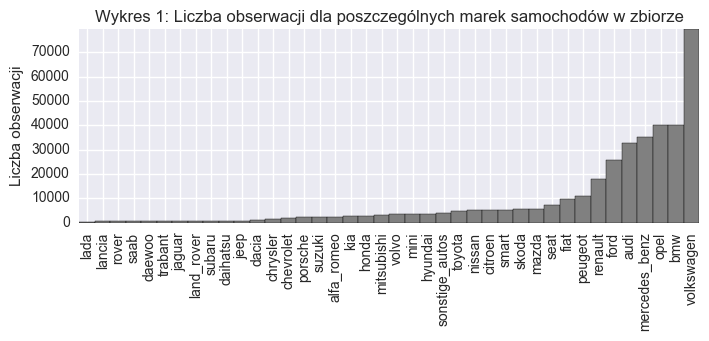

In [46]:
plt.subplot(211)
Y = list(cats_len[-2])
X = np.arange(len(Y))
cats_labels = [x for (y,x) in sorted(zip(Y, cats[-2]))]
Y = sorted(Y)
s = 1
plt.bar(X-s/2, Y, s, color = "gray")
plt.xticks(X, cats_labels, rotation = 90)
plt.axis("tight")
plt.ylabel("Liczba obserwacji")
plt.title("Wykres 1: Liczba obserwacji dla poszczególnych marek samochodów w zbiorze")
plt.show()

### 1.3. Usuwanie części danych i reorganizacja kategorii

In [47]:
#usuwanie kolumn
cars = cars.drop(["dateCrawled", 
                  "name", 
                  "seller", 
                  "offerType", 
                  "abtest", 
                  "model", 
                  "monthOfRegistration", 
                  "postalCode",
                  "dateCreated",
                  "lastSeen"], 
                  axis = 1)

#usunięcie kategorii andere i nan w vehicleType
cars.vehicleType = cars.vehicleType.cat.remove_categories(["andere"])
#usunięcie kategorii andere, elektro, hybrid i nan w fuelType
cars.fuelType = cars.fuelType.cat.remove_categories(["elektro", "hybrid", "andere"])
#usunięcie kategorii inne samochody (sonstige autos) z kategorii marka
cars.brand = cars.brand.cat.remove_categories(["sonstige_autos"])
#połączenie kategorii lpg i cng w kategorię gas
cars.fuelType = cars.fuelType.cat.add_categories("gas")
cars.fuelType[(cars.fuelType == "cng") | (cars.fuelType == "lpg")] = "gas"
cars.fuelType = cars.fuelType.cat.remove_categories(["cng", "lpg"])
#usunięcie pustej kategorii z kolumn
cars.gearbox.cat.remove_unused_categories()
cars.fuelType.cat.remove_unused_categories()
cars.brand.cat.remove_unused_categories()
cars.notRepairedDamage.cat.remove_unused_categories()
cars.vehicleType.cat.remove_unused_categories()

cars = cars.dropna() #usuwanie wszystkich wierszy, w których występują puste dane

### 1.4. Przygotowanie danych numerycznych
W kolumnie **price** znajdują się ceny samochodów. Maksymalna wartość jest błędna i wynosi 99999999. Górny zakres cen zostanie obcięty do 50 000 euro - droższe samochody nie są potrzebne w tej analizie. Dolny zakres po zapoznaniu się z histogramem został ustalony na 80 euro.

Kolumna **yearsOfRegistration** zawiera lata rejestracji samochodów w ogłoszeniach. Minimum w tym przypadku wynosi 1910, a maksimum 2018. Dane w tej kolumnie zostaną obcięte do lat 1990 - 2016, ponieważ starsze samochody mogą być traktowane jako zabytkowe, natomiast dane pochodzą z 2016 roku, więc nie może być w zbiorze przyszłych samochodów.

Kolumna **powerPS** zawiera wartość mocy silnika w koniach mechanicznych. Zakres tej kategorii zostanie ustalony jako 25 - 500 (czyli od malucha do porsche). W wyborze górnej granicy pomógł histogram by zobaczyć do jakich wartości występują duże liczby rekordów.

Rekordy w kolumnie **kilometer** są w zakresie od 5000 do 150000. Są to rozsądne wielkości, kolumna więc pozostanie bez zmian.

Kolumna **nrOfPictures** najpewniej w wyniku błędnego pobrania danych jest pusta, zostanie więc usunięta z analizy.

In [48]:
def num_cols_desc(cols_list):
    for i in num_cols:
        print("KOLUMNA: %s, MIN = %1.f, MAX = %1.f, ŚREDNIA = %1.f" % (i, 
                                                                       cars[i].describe()[3],
                                                                       cars[i].describe()[7],
                                                                       cars[i].describe()[1]))
num_cols = ["price", "yearOfRegistration", "powerPS", "kilometer", "nrOfPictures"]
num_cols_desc(num_cols)

price_hist = np.histogram(cars.price[cars.price < 101], bins = 8)
price_hist_zip = zip(price_hist[0], price_hist[1])
print("\nHistogram dla kolumny price w formie [(liczba wystąpień, początek przedziału), (...), ...]: \n", 
      list(price_hist_zip))

power_hist = np.histogram(cars.powerPS[(cars.powerPS > 299) & (cars.powerPS < 701) ], bins = 8)
power_hist_zip = zip(power_hist[0], power_hist[1])
print("\nHistogram dla kolumny powerPS w formie [(liczba wystąpień, początek przedziału, (...), ...]: \n", 
      list(power_hist_zip))

KOLUMNA: price, MIN = 0, MAX = 99999999, ŚREDNIA = 8216
KOLUMNA: yearOfRegistration, MIN = 1910, MAX = 2018, ŚREDNIA = 2003
KOLUMNA: powerPS, MIN = 0, MAX = 20000, ŚREDNIA = 126
KOLUMNA: kilometer, MIN = 5000, MAX = 150000, ŚREDNIA = 124256
KOLUMNA: nrOfPictures, MIN = 0, MAX = 0, ŚREDNIA = 0

Histogram dla kolumny price w formie [(liczba wystąpień, początek przedziału), (...), ...]: 
 [(3937, 0.0), (8, 12.5), (8, 25.0), (8, 37.5), (114, 50.0), (24, 62.5), (60, 75.0), (399, 87.5)]

Histogram dla kolumny powerPS w formie [(liczba wystąpień, początek przedziału, (...), ...]: 
 [(3487, 300.0), (896, 350.0), (536, 400.0), (288, 450.0), (283, 500.0), (101, 550.0), (37, 600.0), (10, 650.0)]


In [49]:
#usunięcie obserwacji, w których wartości znajdują się poza określonym przedziałem
cars = cars[(cars.price <= 50000) & (cars.price >= 80)]
cars = cars[(cars.yearOfRegistration <= 2017) & (cars.yearOfRegistration >= 1990)]
cars = cars[(cars.powerPS <= 500) & (cars.powerPS >= 25)]

#usunięcie kolumny nrOfPictures
cars = cars.drop(["nrOfPictures"], axis = 1)
num_cols_desc(num_cols.remove("nrOfPictures"))

KOLUMNA: price, MIN = 80, MAX = 50000, ŚREDNIA = 6497
KOLUMNA: yearOfRegistration, MIN = 1990, MAX = 2017, ŚREDNIA = 2004
KOLUMNA: powerPS, MIN = 25, MAX = 500, ŚREDNIA = 128
KOLUMNA: kilometer, MIN = 5000, MAX = 150000, ŚREDNIA = 124355


### 1.5. Przygotowanie danych typu data i czas
Dane typu data i czas zostały usunięte w Podrozdziale 1.3., ponieważ nie są potrzebne w dalszej analizie.

### 1.6. Podsumowanie przygotowania danych
Po etapie przygotowania danych w ramce danych pozostało 9 kolumn:
- **price** - cena samochodu w euro
- **vehicleType** - typ samochodu dany w kategoriach tłumaczonych jako suv, kabriolet, kombi, małe, bus, limuzyna, coupe
- **yearOfRegistration** - rok pierwszej rejestracji samochodu
- **gearbox** - rodzaj skrzyni biegów: manualna lub automatyczna
- **powerPS** - moc samochodu w koniach mechanicznych
- **kilometer** - przebieg samochodu w kilometrach
- **fuelType** - rodzaj paliwa w kategoriach: benzyna, diesel, gaz
- **brand** - marka samochodu (39 kategorii)
- **notRepairedDamage** - czy samochód jest uszkodzony w tym momencie

Poniżej zamieszczone są wykresy przedstawiające przygotowane dane. Na Wykresie 2 można zobaczyć liczbę samochodów o danym typie skrzyni biegów rejestrowaną w każdym roku oraz liczbę samochodów wykorzystujących dany rodzaj paliwa. Na podstawie wykresów można wnioskować, że samochody z automatyczną skrzynią biegów stały się bardziej popularne dopiero w XXI wieku, a po roku 2010 rejestrowanych ich było już tylko o połowę mniej niż samochodów z manualną skrzynią biegów. Po 2005 roku rejestruje się tyle samo samochodów w dieslu co benzynowych.

Wykres 3 przedstawia procentowy udział samochodów nieuszkodzonych do wszystkich w zależności od typu samochodu. Jak widać najwięcej uszkodzonych jest małych samochodów i kombi (kolejno prawie 12% i 11%). Wyjaśnieniem być może jest, że to te rodzaje samochodów najczęściej służą jako podstawowe do codziennego poruszania się. Kierowcy kabrioletów najbardziej dbają o swoje samochody (tylko 5% uszkodzonych).

In [50]:
print(list(cars.head()))

['price', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'kilometer', 'fuelType', 'brand', 'notRepairedDamage']


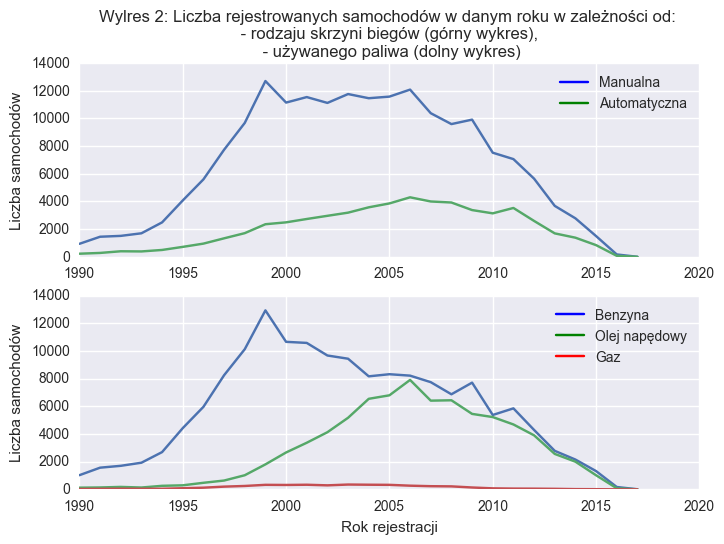

In [51]:
plt.subplot(2, 1, 1)
gb_by_regyear = [cars.gearbox[cars.yearOfRegistration == i].value_counts() for i in range(1990, 2018)]
plt.ylabel("Liczba samochodów")
plt.title("Wylres 2: Liczba rejestrowanych samochodów w danym roku w zależności od: \n - rodzaju skrzyni biegów (górny wykres), \n - używanego paliwa (dolny wykres)")
plt.plot([i for i in range(1990, 2018)], gb_by_regyear)
plt.plot([1990], [1500], color = "blue", label = "Manualna")
plt.plot([1990], [1500], color = "green", label = "Automatyczna")
plt.legend()

plt.subplot(2, 1, 2)
plt.ylabel("Liczba samochodów")
plt.xlabel("Rok rejestracji")
ft_by_regyear = [cars.fuelType[cars.yearOfRegistration == i].value_counts() for i in range(1990, 2018)]
plt.plot([i for i in range(1990, 2018)], ft_by_regyear)
plt.plot([1990], [1500], color = "blue", label = "Benzyna")
plt.plot([1990], [1500], color = "green", label = "Olej napędowy")
plt.plot([1990], [1500], color = "red", label = "Gaz")
plt.legend()
plt.show()

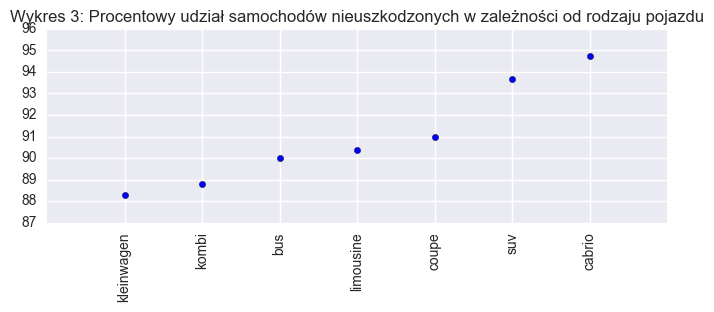

In [52]:
repaired_sum = {i : cars.notRepairedDamage[cars.vehicleType == i].value_counts()[1] + cars.notRepairedDamage[cars.vehicleType == i].value_counts()[0] for i in cars.vehicleType.cat.categories}
categories = cars.vehicleType.cat.categories
plt.subplot(2, 1, 1)
nrd_by_vehtype = [100 * cars.notRepairedDamage[cars.vehicleType == i].value_counts()[1] / repaired_sum[i] for i in cars.vehicleType.cat.categories]

categories = [x for (y,x) in sorted(zip(nrd_by_vehtype, categories))]
nrd_by_vehtype = sorted(nrd_by_vehtype)

plt.scatter([i for i in range(len(cars.vehicleType.cat.categories))], nrd_by_vehtype)
plt.xticks([i for i in range(7)], categories, rotation = 90)
plt.title("Wykres 3: Procentowy udział samochodów nieuszkodzonych w zależności od rodzaju pojazdu")
plt.show()

## 2. Analiza danych

### 2.1. Określenie korelacji dla danych numerycznych
Dane skorelowane mogą wpływać na pogorszenie się modelu, stąd by ich uniknąć wykonane zostało sprawdzenie korelacji. Jak widać najsilniej skorelowaną parą jest cena - rok rejestracji samochodu (korelacja przeciętna 0.66), co wydaje się być zgodne z intuicją. Im samochód starszy tym tańszy. Zupełnie nieskorelowane są ze sobą zmienne moc - przebieg (korelaja 0.0), co również nie dziwi.

Wykres 4 przedstawia rozrzut wartości dla najbardziej skorelowanej pary.

In [53]:
cars_numerical = cars.loc[:, ["price", "powerPS", "kilometer", "yearOfRegistration"]]
corel = cars_numerical.corr("pearson")
corel = corel.where(np.triu(np.ones(corel.shape, 
                                    dtype = np.bool), 
                            k = 1)).stack().sort_values()
print(corel)

kilometer  yearOfRegistration   -0.533992
price      kilometer            -0.486508
powerPS    kilometer             0.001868
           yearOfRegistration    0.223364
price      powerPS               0.582747
           yearOfRegistration    0.654940
dtype: float64


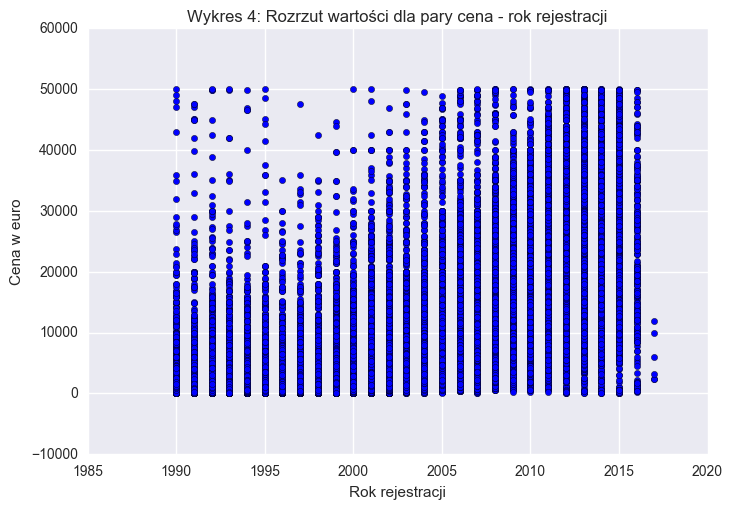

In [54]:
plt.scatter(y = cars.price, x = cars.yearOfRegistration)
plt.title("Wykres 4: Rozrzut wartości dla pary cena - rok rejestracji")
plt.xlabel("Rok rejestracji")
plt.ylabel("Cena w euro")
plt.show()

### 2.2. Dodatkowe przygotowanie danych dla anaizy regresji
Poniżej tworzone są kolumny  zero jedynkowe z danych kategorycznych by dało się w oparciu o nie przeprowadzić analizę regresji. Marki samochodów zostały pominięte ze względu na ich dużą liczbę, która uniemożliwia przeprowadzenie analizy na domowym komputerze.

In [55]:
fuel_d = pd.get_dummies(cars.fuelType, prefix = "fuel").iloc[:, 1:]
gear_d = pd.get_dummies(cars.gearbox, prefix = "gearbox").iloc[:, 1:]
veh_d = pd.get_dummies(cars.vehicleType).iloc[:, 1:]
rep_d = pd.get_dummies(cars.notRepairedDamage, prefix = "damaged").iloc[:, 1:]

#tworzenie ramki danych o odpowiednich kolumnach
cars_reg = cars.loc[:, ["powerPS", "kilometer", "yearOfRegistration"]]
cars_reg = pd.concat([cars_reg, fuel_d, gear_d, veh_d, rep_d], axis = 1)

cars_reg.head()

,powerPS,kilometer,yearOfRegistration,fuel_diesel,fuel_gas,gearbox_manuell,cabrio,coupe,kleinwagen,kombi,limousine,suv,damaged_nein
1,190,125000,2011,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,75,150000,2001,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,69,90000,2008,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,102,150000,1995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,109,150000,2004,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## 3. Analiza regresji
Analiza regresji zostanie przeprowadzona dla 5 różnych modeli: o zmiennych liniowych, o zmiennych wielomianowych oraz trzech modeli o zmiennych wielomianowych dobieranych według kryteriów Schwarza, Akaike i progu wariancji. W każdym z przypadków dane zostaną podzielone na część uczącą i część testową w stosunku 80% do 20% całego zbioru.

Analiza została przeprowadzona w oparciu o rozdział 14.2 książki *Przetwarzanie i analiza danych w języku Python* M. Gągolewskiego i in. Kod został w większości przypadków przepisany bez zmian, lecz ze zrozumieniem.

In [56]:
import sklearn.linear_model
import sklearn.metrics
import sklearn.cross_validation
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.svm

In [57]:
#określenie nazw kolumn utworzonych w Podrozdziale 2.2.
col_names = ["powerPS",
             "kilometer",
             "yearOfRegistration",
             "fuel_diesel",
             "fuel_gas",
             "gearbox_manuell",
             "cabrio",
             "coupe",
             "kleinwagen",
             "kombi",
             "limousine",
             "suv",
             "damaged_nein"]

X = cars_reg[col_names]
y = cars.price

X_ucz, X_test, y_ucz, y_test = sklearn.cross_validation.train_test_split(X, y, test_size = 0.2, random_state = 12345)

In [58]:
#definicja funkcji dla określenia kryterium BIC oraz AIC
def BIC(mse, p, n):
    return n*np.log(mse) + p*np.log(n)

def AIC(mse, p, n):
    return n*np.log(mse) + 2*p

#definicja funkcji przeprowadzającej regresję liniową i podsumowującej parametry
def fit_regression(X_ucz, X_test, y_ucz, y_test):
    r = sklearn.linear_model.LinearRegression()
    r.fit(X_ucz, y_ucz)
    y_ucz_pred = r.predict(X_ucz)
    y_test_pred = r.predict(X_test)
    mse = sklearn.metrics.mean_squared_error
    mae = sklearn.metrics.mean_absolute_error
    n = X_ucz.shape[0]
    p = X_ucz.shape[1]
    return {
        "r_score" : r.score(X_ucz, y_ucz),
        "MSE_u" : mse(y_ucz, y_ucz_pred),
        "MAE_u" : mae(y_ucz, y_ucz_pred),
        "MSE_t" : mse(y_test, y_test_pred),
        "MAE_t" : mae(y_test, y_test_pred),
        "BIC_u" : BIC(mse(y_ucz, y_ucz_pred), p + 1, n),
        "AIC_u" : AIC(mse(y_ucz, y_ucz_pred), p + 1, n),
        "zmienne" : p
    }

### 3.1. Model liniowy
Oprócz modelu liniowego został również utworzony model liniowy dla wystandaryzowanych obserwacji. Dzięki temu uzyskano informacje o istotności współczynników równania. Najbardziej istotną dla ceny zmienną jest moc samochodu oraz rok jego rejestracji.

In [59]:
res = [fit_regression(X_ucz, X_test, y_ucz, y_test)]
params = ["zm. liniowe"]

In [60]:
X_std = (X - X.mean(axis = 0)) / X.std(axis = 0, ddof = 1)
mnk_std = sklearn.linear_model.LinearRegression()
mnk_std.fit(X_std, (y - y.mean()) / y.std(ddof = 1))
print("zmienna, współczynnik (istotność)")
pd.Series(mnk_std.coef_, index = X.columns.tolist()).round(4)

zmienna, współczynnik (istotność)


powerPS               0.4426
kilometer            -0.2928
yearOfRegistration    0.3409
fuel_diesel           0.1192
fuel_gas             -0.0215
gearbox_manuell      -0.0485
cabrio                0.0568
coupe                 0.0277
kleinwagen           -0.0157
kombi                -0.0641
limousine            -0.0257
suv                   0.0462
damaged_nein          0.0607
dtype: float64

### 3.2. Modele wielomianowe
Ze względu na skończoną moc komputera tylko część kolumn zostanie uwzględniona w modelach wielomianowych, w których tworzone są dodatkowe kolumny dla par zmiennych. Do dalszej analizy zostały wybrane tylko kolumny, które uzysały istotność o wartości wyższej niż 0,05. 

In [61]:
col_names2 = ["powerPS",
              "kilometer",
              "yearOfRegistration",
              "fuel_diesel",
              "damaged_nein",
              "kombi",
              "cabrio"]

X2 = cars_reg[col_names2]

#model wielomianowy
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree = 2, include_bias = False)
X2 = poly_transform.fit_transform(X2)

X2_ucz, X2_test, y_ucz, y_test = sklearn.cross_validation.train_test_split(X2, y, test_size = 0.2, random_state = 12345)

params.append("zm. wielom.")
res.append(fit_regression(X2_ucz, X2_test, y_ucz, y_test))

### 3.3. Dobór kolumn do modelu wielomianowego
By zmniejszyć wymiar zagadnienia lub nawet polepszyć dopasowanie modelu można skorzystać z automatycznych metod doboru tylko niektórych ze wszystkich kolumn. Poniżej znajduje się implementacja procedur wyboru zmiennych opartych na kryteriach Schwarza oraz Akaike.
W Podrozdziale 3.3.3. zmienne do modelu są wybierane na podstawie wariancji, dzięki funkcji w pakiecie *sklearn.feature_selection*.

In [62]:
def forward_selection_BIC(X, y):
    n, m = X.shape
    best_idx = []
    best_free = set(range(m))
    best_fit = np.inf
    res = []
    for i in range(0, m):
        cur_idx = -1
        cur_fit = np.inf
        for e in best_free:
            r = sklearn.linear_model.LinearRegression()
            test_idx = best_idx + [e]
            r.fit(X[:, test_idx], y)
            test_fit = BIC(sklearn.metrics.mean_squared_error(y, r.predict(X[:,test_idx])), i+2, n)
            if test_fit < cur_fit: cur_idx, cur_fit = e, test_fit
        if cur_fit > best_fit: break
        best_idx, best_fit = best_idx + [cur_idx], cur_fit
        best_free.discard(cur_idx)
        res.append((cur_idx, cur_fit))
    return res

def forward_selection_AIC(X, y):
    n, m = X.shape
    best_idx = []
    best_free = set(range(m))
    best_fit = np.inf
    res = []
    for i in range(0, m):
        cur_idx = -1
        cur_fit = np.inf
        for e in best_free:
            r = sklearn.linear_model.LinearRegression()
            test_idx = best_idx + [e]
            r.fit(X[:, test_idx], y)
            test_fit = AIC(sklearn.metrics.mean_squared_error(y, r.predict(X[:,test_idx])), i+2, n)
            if test_fit < cur_fit: cur_idx, cur_fit = e, test_fit
        if cur_fit > best_fit: break
        best_idx, best_fit = best_idx + [cur_idx], cur_fit
        best_free.discard(cur_idx)
        res.append((cur_idx, cur_fit))
    return res

### 3.3.1. Analiza regresji dla wyboru zmiennych BIC

In [65]:
X3 = cars_reg[col_names2]
X3 = poly_transform.fit_transform(X3)

wybrane = pd.DataFrame(forward_selection_BIC(X3, y), columns = ["zmienna", "BIC"])
wybrane_zmienne = wybrane["zmienna"].tolist()
X3_names = cars_reg[col_names2]
wybrane["nazwa"] = [X3_names.columns[w>=1].append(X3_names.columns[w==2]).str.cat(sep="*") for w in poly_transform.powers_[wybrane_zmienne]]
X3_BIC = X3[:, wybrane_zmienne]
print(wybrane)

    zmienna           BIC                                  nazwa
0        20  4.177848e+06  yearOfRegistration*yearOfRegistration
1         9  4.072104e+06             powerPS*yearOfRegistration
2         2  3.995794e+06                     yearOfRegistration
3         0  3.952033e+06                                powerPS
4         8  3.929896e+06                      powerPS*kilometer
5        26  3.921341e+06               fuel_diesel*damaged_nein
6        13  3.911159e+06                         powerPS*cabrio
7        16  3.906504e+06                  kilometer*fuel_diesel
8        10  3.902995e+06                    powerPS*fuel_diesel
9        11  3.899785e+06                   powerPS*damaged_nein
10       27  3.896635e+06                      fuel_diesel*kombi
11        1  3.894425e+06                              kilometer
12       21  3.893028e+06         yearOfRegistration*fuel_diesel
13       19  3.892056e+06                       kilometer*cabrio
14       17  3.891285e+06

In [66]:
params.append("zm. wybrane BIC")
res.append(fit_regression(X2_ucz[:, wybrane_zmienne], X2_test[:, wybrane_zmienne], y_ucz, y_test))

### 3.3.2. Analiza regresji dla wyboru zmiennych AIC

In [67]:
wybrane = pd.DataFrame(forward_selection_AIC(X3, y), columns = ["zmienna", "AIC"])
wybrane_zmienne = wybrane["zmienna"].tolist()
X3_names = cars_reg[col_names2]
wybrane["nazwa"] = [X3_names.columns[w>=1].append(X3_names.columns[w==2]).str.cat(sep="*") for w in poly_transform.powers_[wybrane_zmienne]]
X3_AIC = X3[:, wybrane_zmienne]
print(wybrane)

    zmienna           AIC                                  nazwa
0        20  4.177827e+06  yearOfRegistration*yearOfRegistration
1         9  4.072073e+06             powerPS*yearOfRegistration
2         2  3.995753e+06                     yearOfRegistration
3         0  3.951981e+06                                powerPS
4         8  3.929834e+06                      powerPS*kilometer
5        26  3.921268e+06               fuel_diesel*damaged_nein
6        13  3.911076e+06                         powerPS*cabrio
7        16  3.906410e+06                  kilometer*fuel_diesel
8        10  3.902891e+06                    powerPS*fuel_diesel
9        11  3.899670e+06                   powerPS*damaged_nein
10       27  3.896510e+06                      fuel_diesel*kombi
11        1  3.894289e+06                              kilometer
12       21  3.892883e+06         yearOfRegistration*fuel_diesel
13       19  3.891900e+06                       kilometer*cabrio
14       17  3.891119e+06

In [68]:
params.append("zm. wybrane AIC")
res.append(fit_regression(X2_ucz[:, wybrane_zmienne], X2_test[:, wybrane_zmienne], y_ucz, y_test))

### 3.3.3. Analiza regresji dla wyboru metodą VarianceThreshold

In [69]:
X4 = sklearn.feature_selection.VarianceThreshold(threshold = (.8 * (1 - .8))).fit_transform(X2)
X4_ucz, X4_test, y_ucz, y_test = sklearn.cross_validation.train_test_split(X4, y, test_size = 0.2, random_state = 12345)

params.append("zm. wybrane war.")
res.append(fit_regression(X4_ucz, X4_test, y_ucz, y_test))

## 4. Podsumowanie wyników analizy regresji
Wyjaśnienie skrótów:
- **AIC_u** wartość kryterium Akaike dla modelu opartego o zbiór uczący
- **BIC_u** wartość kryterium Schwarza dla modelu opatego o zbiór uczący
- **MAE_t** średnia z modułów różnic dla zbioru testowego
- **MAE_t** średnia z modułów różnic dla zbioru uczącego
- **MSE_t** błąd średniokwadratowy dla zbioru testowego
- **MSE_u** błąd średniokwadratowy dla zbioru uczącego
- **r_score** współczynnik R kwadrat

Jak widać model liniowy został przygotowany na 13 zmiennych, a model wielomianowy na 35. Dobór zmiennych w oparciu o kryterium BIC poskutkował wybraniem 26 zmiennych, w oparciu o kryterium AIC 29 zmiennych, a metodą VarianceThreshold 26 zmiennych. 

Najlepsze dopasowanie R2 (0.8282) uzyskały wspólnie: model wielomianowy dla 35 zmiennych oraz model o zmiennych wybranych (AIC) dla 29 zmiennych. Model dla zmiennych wybranych (BIC) był niewiele gorszy dla 26 zmiennych z wynikiem R2 (0.8280). Najmniejszą wartość kryterium Akaike uzyskał model dla zmiennych wybranych (AIC), co może świadczyć o tym, że algorytm doboru został poprawnie przygotowany. Średnia z modułów różnic wynosi dla wszystkich modeli oprócz liniowego około 1770 euro. Jest to duża wartość w przypadku szacowania ceny samochodu, którego wartość nie przekracza 10000 euro. Model o zmiennych liniowych spisał się najgorzej uzysukując współczynnik R2 0.71 oraz średnią z modułów różnic ponad 2600 euro.

In [70]:
pd.DataFrame(res, index = params)

,AIC_u,BIC_u,MAE_t,MAE_u,MSE_t,MSE_u,r_score,zmienne
zm. liniowe,3.209490e+06,3.209633e+06,2640.357555,2625.981208,1.471918e+07,1.439581e+07,0.711140,13
zm. wielom.,3.108278e+06,3.108645e+06,1775.362145,1756.333581,8.941049e+06,8.558535e+06,0.828268,35
zm. wybrane BIC,3.108528e+06,3.108802e+06,1777.166575,1758.364909,8.951178e+06,8.570292e+06,0.828032,26
zm. wybrane AIC,3.108266e+06,3.108572e+06,1775.380739,1756.353681,8.941020e+06,8.558536e+06,0.828268,29
zm. wybrane war.,3.109663e+06,3.109937e+06,1784.884961,1765.218500,9.008813e+06,8.620397e+06,0.827027,26


### 4.1. Szacowanie cen samochodów o znanej wartości
Poniżej przedstawiono szacowanie ceny samochodów autora raportu, tj. Skoda Fabia oraz Ford Mondeo. Szacowanie zostało wykonane dla modelu wielomianowego o 35 zmiennych. Cena wysłużonej Skody powinna zamknąć się w okolicach 1000 zł (250 euro), natomiast trochę nowszego Forda w okoliach 5000 złotych (1250 euro). Porównanie, rzecz jasna, jest bardziej dla zabawy i z ciekawości, mimo wszystko (być może przypadkiem) szacowane ceny są zbliżone do zakładanych.

In [71]:
skoda = np.array([54, 163000, 2001, 0.0, 1.0, 0.0, 0.0]).reshape(1, 7)
skoda = pd.DataFrame(skoda)
skoda.loc[1] = [75, 140000, 2003, 0.0, 1.0, 0.0, 0.0]

skoda = poly_transform.fit_transform(skoda)
r = sklearn.linear_model.LinearRegression()
r.fit(X2_ucz, y_ucz)
skoda_price = r.predict(skoda)
print("Szacowana cena Skody Fabia, r. 2001, 54 KM, nieuszkodzonej, przebieg 163000:", round(skoda_price[0], 1), "euro")
print("Szacowana cena Forda Mondeo, r. 2003, 75 KM, nieuszkodzonego, przebieg 140000:", round(skoda_price[1], 1), "euro")

Szacowana cena Skody Fabia, r. 2001, 54 KM, nieuszkodzonej, przebieg 163000: 310.0 euro
Szacowana cena Forda Mondeo, r. 2003, 75 KM, nieuszkodzonego, przebieg 140000: 1627.9 euro


### 4.1.1. Szacowanie cen samochodów ze zbioru
Dla wizualnej i intuicyjnej oceny modelu poniżej została przedstawiona tabela dla pierwszych 8 samochodów ze zbioru z cenami szacunkowymi oraz referencyjnymi.

In [73]:
b = list(y[0:8])
c = list(r.predict(X2[0:8]))
d = list(r.predict(X2[0:8]) / y[0:8])
tabela = ["szacowanie", "war. ref.", "błąd względny"]
pd.DataFrame([c, b, d], index = tabela)

,0,1,2,3,4,5,6,7
szacowanie,14285.761557,1029.654889,6305.800208,1204.195005,3590.193782,2954.977593,3285.639478,21797.739000
war. ref.,18300.000000,1500.000000,3600.000000,650.000000,2200.000000,2000.000000,2799.000000,17999.000000
błąd względny,0.780643,0.686437,1.751611,1.852608,1.631906,1.477489,1.173862,1.211053


## 5. Wnioski

Niestety przez nie wystarczającą moc komputera (pamięć, procesor) nie udało się wykorzystać wszystkich danych do analizy. Mimo to, wyniki są porawne i mniej więcej przy pomocy utworzonych modeli daje się szacować cenę samochodu. Ta jednak zależy od wielu więcej czynników, o których nie ma żadnych informacji w danych. Dlatego może nie jest zdziwieniem dość duża średnia z modułu różnic dla modeli (około 2000 euro). 

Dla modelu wielomianowego udało uzyskać się wysoki współczynnik R2 wynoszący 0.83. Wybór tylko części zmiennych w oparciu o kryterium BIC lub AIC nie przyniosło poprawy miary dopasowania i błędów, lecz odchudziło model ze zmiennych, co także jest ważne.

### Co można poprawić

1. Podczas przygotowania danych usuniętych zostało wiele rekordów pustych dla kolumn, które jak się okazało później nie są istotne na cenę np. rodzaj skrzyni biegów. W ponownej analizie warto rozważyć pozostawienie tych rekordów co zwiększy liczbę danych w analizie regresji.

2. By poprawić wyniki średniego modułu różnic można rozważyć analizę na wycinku danych tylko dla danego typu samochodów lub w danym zakresie cenowym. Wydaje się, że rozrzut obserwacji w zbiorze jest bardzo duży nawet po przygotowaniu co jest nie bez znaczenia na przewidywanie ceny.

3. Zadanie zostało wykonane tylko dla jednego stosunku liczby obserwacji w zbiorze uczącym do testowego. Warto rozważyć sprawdzenie dla innych wartości.

4. W analizie został wykorzystny model regresji o domyślnych ustawieniach. Być może przez zmianę ustawień dałoby się uzykać lepsze wartości dopasowania czy mniejsze błędy.

### Odczucia autora

Jestem zadowolony z wykonanego zadania, a przede wszystkim zdobycia wiedzy i umiejętności jakie to wykonanie za sobą niosło. Powyższa analiza zmusiła mnie do sięgniecia do książek, notatek ze wszystkich 3 przedmiotów oraz zrozumienia i poukładania wiedzy, którą prowadzący starali się przekazać na studiach podyplomowych. Zadanie pokazało mi również jak duże i wymagające są projekty analizy danych, gdy te dane trzeba dopiero zrozumieć, przygotować i analizować. Przy okazji wykonania tych zadań wychodzi wiele problemów, których unika się korzystając na ładnie przygotowanych, szkolnych danych. Korzystałem z tabletu do wykonania tej analizy (4 rdzenie 1.44 Ghz, 2 GB RAM (w rzeczywistości mniej przez system W10 na pokładzie)), więc odczułem niechcąco problemy z "BIG data" - wieczny brak pamięci i długie oczekiwanie na wykonanie poleceń. Jestem świadomy, że ten problem wymusza w branży bycie specjalistą by pisać szybki i bezbłędny kod i korzystać ze sprawdzonych i zoptymalizowanych metod, ponieważ inaczej nie wyskoczy się poza te szkolne zadania z zajęć. Zadanie opracowywałem przez długi czas i tym samym pierwsze podrozdziały, a ściślej ujmując kod w nich zawarty jest daleki od ideału i napisany mocno na okrętkę (jeszcze nie znałem wielu metod), ale działa i zostawiłem go jako przestrogę dla samego siebie by nie wyważać otwartych drzwi raz jeszcze. Na co dzień zajmuję się obliczeniami wytrzymałościowymi zupełnie niezwiązanymi z tematem studiów, więc tym bardziej cieszy mnie to co zrobiłem, a najbardziej, że znajduję w tym zainteresowanie. 